## 5 Decision Tree

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format = 'retina'

In [2]:
# 1) Load data.

X_and_Y = np.load('ionosphere.npy').astype(np.float32) # Load data from file.
np.random.shuffle(X_and_Y)   # Shuffle the data.
X = X_and_Y[:, 0:-1]         # First column to second last column: Features (numerical values) 
Y = X_and_Y[:, -1]           # Last column: Labels (0 or 1)
print(X.shape, Y.shape)      # Check the shapes.

(351, 34) (351,)


In [3]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.8*len(X))] # Get features from train + val set.
X_test      = X[int(0.8*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.8*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.8*len(Y)):] # Get labels from test set.
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(280, 34) (71, 34) (280,) (71,)


In [4]:
# 3) Perform grid search for best D using sklearn
classifiers = tree.DecisionTreeClassifier()
D_list = [1,2,3,4,5]
param_dist = {
              "max_depth": D_list,
              "criterion": ["entropy"]
             }
clf = GridSearchCV(classifiers, param_dist, return_train_score = 'true',cv =5)
clf.fit(X_train_val, Y_train_val)
print(clf.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [5]:
C = clf.best_params_['max_depth']
C

3

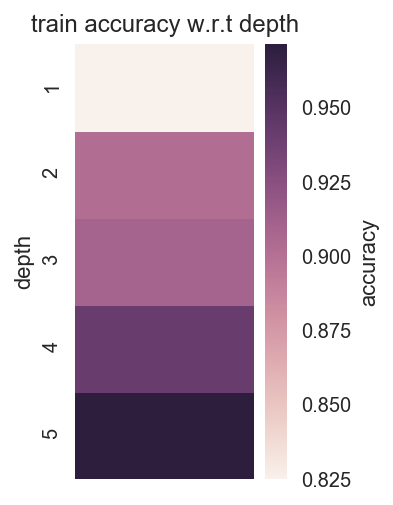

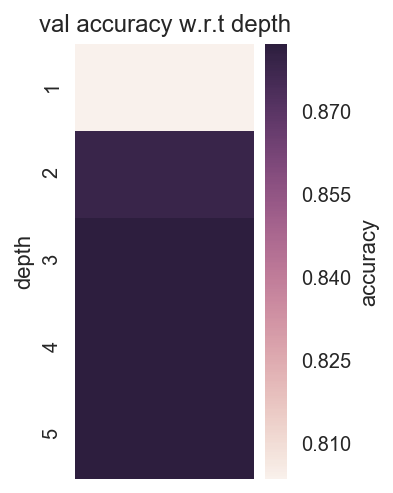

In [6]:
# 4) Draw heatmaps for result of grid search and find 
#    optimal D for validation set.
def draw_heatmap_linear(acc, acc_desc, depth_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=depth_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='depth')
    plt.title(acc_desc + ' w.r.t depth')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
    
#######FILL IN HERE #########   
train_acc = clf.cv_results_['mean_train_score']
draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', D_list)

val_acc = clf.cv_results_['mean_test_score']
draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', D_list)
# optimal is 1

In [7]:
# 5) Use the optimal D to calculate the test accuracy.
# best depth is 1 so close to 90% like in hint
classifiers = tree.DecisionTreeClassifier()
param_dist = {
              "max_depth": [clf.best_params_['max_depth']],
              "criterion": ["entropy"]
             }
testclf = GridSearchCV(classifiers, param_dist, return_train_score = 'true',cv =5)
testclf.fit(X_train_val, Y_train_val)
test_acc = clf.score(X_test, Y_test)
print(test_acc)

0.929577464789


## 6 K-Nearest Neighbors

In [22]:
# 1) Load data.

X_and_Y = np.load('ionosphere.npy').astype(np.float32) # Load data from file.
np.random.seed(0)
np.random.shuffle(X_and_Y)   # Shuffle the data.
X = X_and_Y[:, 0:-1]         # First column to second last column: Features (numerical values) 
Y = X_and_Y[:, -1]           # Last column: Labels (0 or 1)
print(X.shape, Y.shape)      # Check the shapes.

(351, 34) (351,)


In [23]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.8*len(X))] # Get features from train + val set.
X_test      = X[int(0.8*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.8*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.8*len(Y)):] # Get labels from test set.  
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(280, 34) (71, 34) (280,) (71,)


In [24]:
# 3) Implement the k-NN.
from collections import defaultdict
class simple_KNeighborsClassifier(object):
    def __init__(self, k):
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        self.k = k
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        return self
    
    def _predict_one(self, test):
        distances = sorted((self._distance(x, test), y) for x, y in zip(self.X_train, self.Y_train))
        neighbors = distances[:self.k]
        weights = self._compute_weights(neighbors)
        for a,b in weights:
            return b
    def _compute_weights(self, distances):
        matches = [(1, y) for d, y in distances if d == 0]
        return matches if matches else [(1/d, y) for d, y in distances]
    
    def _distance(self, data1, data2): # euclidean
        return np.sqrt(sum((data1 - data2)**2))

    def predict(self, X_pred):
        """
        k-NN prediction function.
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), )
        """
        
        Y_pred = []
        
        #######FILL IN HERE #########
        for i in X_pred:
            Y_pred.append(self._predict_one(i))
        return np.array(Y_pred)

In [25]:
# 4) Implement the cross-validation.
from sklearn.metrics import accuracy_score
def simple_cross_validation(X_train_val, Y_train_val, k, fold):
    """
    A simple cross-validation function for k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k:           Parameter k for k-NN.
    fold:        The number of folds to do the cross-validation.
    
    Return the average accuracy on validation set.
    """
    val_acc_list = []
    train_acc_list = []
    number = len(Y_train_val)//fold
    for i in range(fold):
        X_test = X_train_val[i*number:(i+1)*number,:]
        Y_test = Y_train_val[i*number:(i+1)*number]
        X_train = np.delete(X_train_val, slice(i*number,(i+1)*number),axis = 0)
        Y_train = np.delete(Y_train_val, slice(i*number,(i+1)*number),axis = 0)
        newSVM = simple_KNeighborsClassifier(k)
        newSVM.fit(X_train,Y_train)
        train_arr = newSVM.predict(X_train)
        val_arr = newSVM.predict(X_test)
        train =(accuracy_score(Y_train, train_arr))
        val = (accuracy_score(Y_test, val_arr))
        val_acc_list.append(val)
        train_acc_list.append(train)
    return sum(val_acc_list) / len(val_acc_list), \
           sum(train_acc_list) / len(train_acc_list)

In [26]:
# 5) Implement the grid search function.

def simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, fold):
    """
    A simple grid search function for k with cross-validation in k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k_list:      The list of k values to try.
    fold:        The number of folds to do the cross-validation.
    
    Return the val and train accuracy matrix of cross-validation. 
    All combinations of k are included in the array. 
    Shape: (len(k_list), )
    """
    val_acc_array = np.zeros(len(k_list))
    train_acc_array = np.zeros(len(k_list))
    for i in range(len(k_list)):
        val_acc_array[i], train_acc_array[i] = simple_cross_validation(
            X_train_val, Y_train_val, k_list[i], fold)
    return val_acc_array, train_acc_array

In [27]:
# 6) Perform grid search.
k_list = [1,2,3,4,5,6]
val_acc_array, train_acc_array = simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, 3)

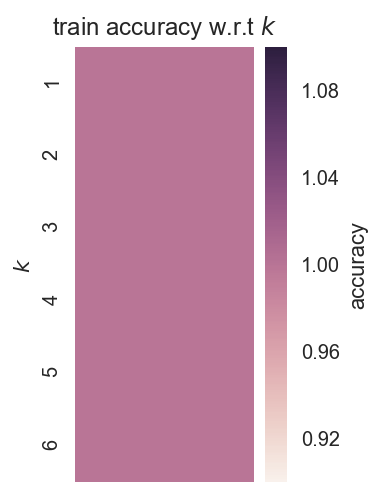

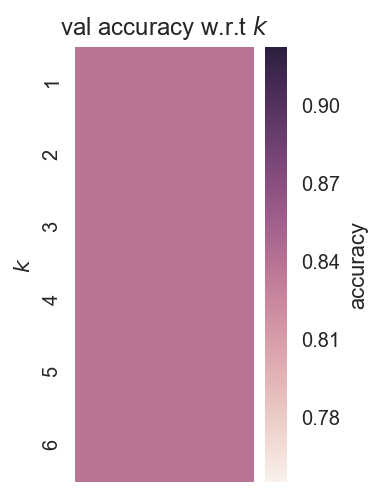

In [28]:
# 7) Draw heatmaps for result of grid search and find 
#    best k on validation set.

def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$k$')
    plt.title(acc_desc + ' w.r.t $k$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

#######FILL IN HERE #########

# Hint:
# You can use the draw_heatmap_knn() to draw a heatmap to visualize 
# the accuracy w.r.t. k. Some demo code is given below as hint:
#
# demo_acc        = np.array([[0.8],[0.7]])
# demo_k_list     = [1, 2]
# draw_heatmap_linear(demo_acc, 'demo accuracy', demo_k_list)
#
#train_acc = clf.cv_results_['mean_train_score']
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', k_list)

#val_acc = clf.cv_results_['mean_test_score']
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', k_list)

In [29]:
# 8) Use the best k to calculate the test accuracy.

#######FILL IN HERE #########

testclf = simple_KNeighborsClassifier(1)
testclf.fit(X_train_val, Y_train_val)
test_arr = testclf.predict(X_test)
test_acc = (accuracy_score(Y_test, test_arr))
print(test_acc)

0.929577464789


## 7 (Bonus) SVM